# Introduction to Optimal Transport with Python

#### *Rémi Flamary, Nicolas Courty*

## POT installation

+ Install with pip:
```bash
pip install pot
```
+ Install with conda
```bash
conda install -c conda-forge pot
```

## POT Python Optimal Transport Toolbox

#### Import the toolbox

In [1]:
import numpy as np # always need it
import scipy as sp # often use it
import pylab as pl # do the plots

import ot # ot 

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-03-15 10:43:36.774515: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-15 10:43:37.067465: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-15 10:43:37.067496: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-15 10:43:37.069615: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already b

#### Getting help

Online  documentation : [http://pot.readthedocs.io](http://pot.readthedocs.io) 

Or inline help:


In [2]:
help(ot.dist)

Help on function dist in module ot.utils:

dist(x1, x2=None, metric='sqeuclidean', p=2, w=None)
    Compute distance between samples in :math:`\mathbf{x_1}` and :math:`\mathbf{x_2}`
    
    .. note:: This function is backend-compatible and will work on arrays
        from all compatible backends.
    
    Parameters
    ----------
    
    x1 : array-like, shape (n1,d)
        matrix with `n1` samples of size `d`
    x2 : array-like, shape (n2,d), optional
        matrix with `n2` samples of size `d` (if None then :math:`\mathbf{x_2} = \mathbf{x_1}`)
    metric : str | callable, optional
        'sqeuclidean' or 'euclidean' on all backends. On numpy the function also
        accepts  from the scipy.spatial.distance.cdist function : 'braycurtis',
        'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice',
        'euclidean', 'hamming', 'jaccard', 'kulczynski1', 'mahalanobis',
        'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
        'sok

## First OT Problem

We will solve the Bakery/Cafés problem of transporting croissants from a number of Bakeries to Cafés in a City (In this case Manhattan). We did a quick google map search in Manhattan for bakeries and Cafés:

![bak.png](https://remi.flamary.com/cours/otml/bak.png)

We extracted from this search their positions and generated fictional production and sale number (that both sum to the same value).

We have acess to the position of Bakeries ```bakery_pos``` and their respective production ```bakery_prod``` which describe the source distribution. The Cafés where the croissants are sold are defiend also by their position ```cafe_pos``` and ```cafe_prod```. For fun we also provide a map ```Imap``` that will illustrate the position of these shops in the city.


Now we load the data



In [3]:
data=np.load('data/manhattan.npz')

bakery_pos=data['bakery_pos']
bakery_prod=data['bakery_prod']
cafe_pos=data['cafe_pos']
cafe_prod=data['cafe_prod']
Imap=data['Imap']

print('Bakery production: {}'.format(bakery_prod))
print('Cafe sale: {}'.format(cafe_prod))
print('Total croissants : {}'.format(cafe_prod.sum()))

Bakery production: [31. 48. 82. 30. 40. 48. 89. 73.]
Cafe sale: [82. 88. 92. 88. 91.]
Total croissants : 441.0


#### Plotting bakeries in the city

Next we plot the position of the bakeries and cafés on the map. The size of the circle is proportional to their production.


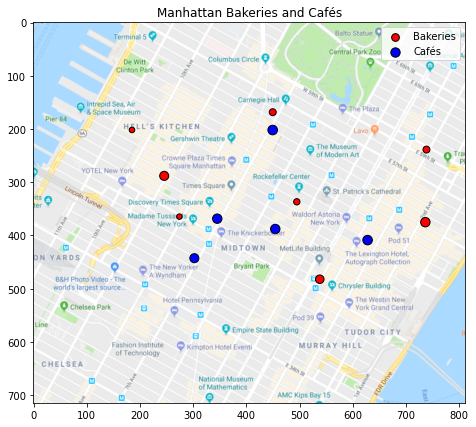

In [4]:

pl.figure(1,(8,7))
pl.clf()
pl.imshow(Imap,interpolation='bilinear') # plot the map
pl.scatter(bakery_pos[:,0],bakery_pos[:,1],s=bakery_prod,c='r', edgecolors='k',label='Bakeries')
pl.scatter(cafe_pos[:,0],cafe_pos[:,1],s=cafe_prod,c='b', edgecolors='k',label='Cafés')
pl.legend()
pl.title('Manhattan Bakeries and Cafés');


#### Cost matrix


We compute the cost matrix between the bakeries and the cafés, this will be the transport cost matrix. This can be done using the [ot.dist](http://pot.readthedocs.io/en/stable/all.html#ot.dist) that defaults to squared euclidean distance but can return other things such as cityblock (or manhattan distance). 



In [8]:
cost_matrix = ot.dist(bakery_pos, cafe_pos, metric='cityblock')
print(cost_matrix)

[[358.1894393  326.95645073 264.4904736  455.35873707 649.69733261]
 [421.64305156 304.34582782  33.6599269  224.28322576 418.62182129]
 [211.33120771 180.09821915 289.98499106 308.50050548 502.83910102]
 [106.2336107   75.00062213 338.00972082 203.40290847 397.741504  ]
 [298.44917956 181.15195583 180.26028463  91.6173886  204.94657438]
 [640.1903725  522.89314877 325.72649506 433.35858154 280.66397076]
 [501.68426783 397.59055914 460.05653628 294.85247686 142.15786609]
 [275.18018508 306.41317365 368.87915079 178.01088732 163.39077689]]


#### Solving the OT problem with [ot.emd](http://pot.readthedocs.io/en/stable/all.html#ot.emd)

In [9]:
help(ot.emd)

Help on function emd in module ot.lp:

emd(a, b, M, numItermax=100000, log=False, center_dual=True, numThreads=1, check_marginals=True)
    Solves the Earth Movers distance problem and returns the OT matrix
    
    
    .. math::
        \gamma = \mathop{\arg \min}_\gamma \quad \langle \gamma, \mathbf{M} \rangle_F
    
        s.t. \ \gamma \mathbf{1} = \mathbf{a}
    
             \gamma^T \mathbf{1} = \mathbf{b}
    
             \gamma \geq 0
    
    where :
    
    - :math:`\mathbf{M}` is the metric cost matrix
    - :math:`\mathbf{a}` and :math:`\mathbf{b}` are the sample weights
    
    .. warning:: Note that the :math:`\mathbf{M}` matrix in numpy needs to be a C-order
        numpy.array in float64 format. It will be converted if not in this
        format
    
    .. note:: This function is backend-compatible and will work on arrays
        from all compatible backends. But the algorithm uses the C++ CPU backend
        which can lead to copy overhead on GPU arrays.
    
  

#### Transportation plan vizualization

A good vizualization of the OT matrix in the 2D plane is to denote the transportation of mass between a Bakery and a Café by a line. This can easily be done with a double ```for``` loop.

In order to make it more interpretable one can also use the ```alpha``` parameter of plot and set it to ```alpha=G[i,j]/G[i,j].max()```. 

#### OT loss and dual variables

The resulting wasserstein loss loss is of the form:

$W=\sum_{i,j}\gamma_{i,j}C_{i,j}$

where $\gamma$ is the optimal transport matrix.


#### Regularized OT with SInkhorn

The Sinkhorn algorithm is very simple to code. You can implement it directly using the following pseudo-code:

![sinkhorn.png](http://remi.flamary.com/cours/otml/sink.png)

An alternative is to use the POT toolbox with [ot.sinkhorn](http://pot.readthedocs.io/en/stable/all.html#ot.sinkhorn)

Be carefull to numerical problems. A good pre-provcessing for Sinkhorn is to divide the cost matrix ```C```
 by its maximum value.